In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
from zipfile import ZipFile
from torchvision.datasets import ImageFolder
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
import torchvision.models as models

In [ ]:
zip_path = 'food_image.zip'
extract_path = 'food11_dataset'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")

Dataset unzipped successfully.


In [ ]:
train_dir = os.path.join(extract_path, 'training')
val_dir = os.path.join(extract_path, 'validation')
test_dir = os.path.join(extract_path, 'evaluation')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])


train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#resnet
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 11)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 79.12%  Train Loss: 0.6567647635068709  Validation Accuracy: 86.65%  Validation Loss: 0.4139009639017146
Epoch: 2  Train Accuracy: 94.79%  Train Loss: 0.18415592018888607  Validation Accuracy: 87.23%  Validation Loss: 0.38495905352411447
Epoch: 3  Train Accuracy: 98.68%  Train Loss: 0.06430675859282751  Validation Accuracy: 89.59%  Validation Loss: 0.351107449684706
Epoch: 4  Train Accuracy: 99.21%  Train Loss: 0.03842834939104189  Validation Accuracy: 88.72%  Validation Loss: 0.415158372464012
Epoch: 5  Train Accuracy: 99.01%  Train Loss: 0.03810978764637967  Validation Accuracy: 85.74%  Validation Loss: 0.5186119005773906


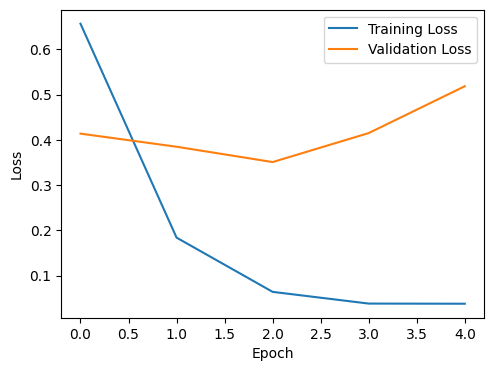

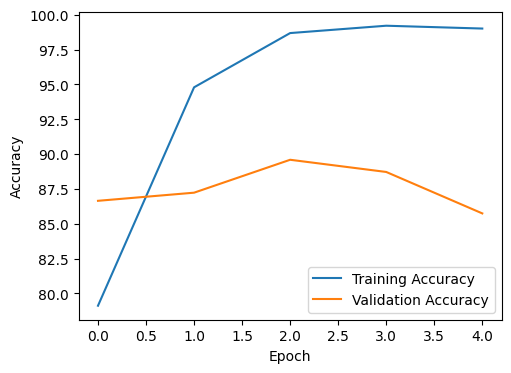

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [ ]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 88 %
Test Loss: 0.41576799858982366


In [ ]:
#Confusion Matrix
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

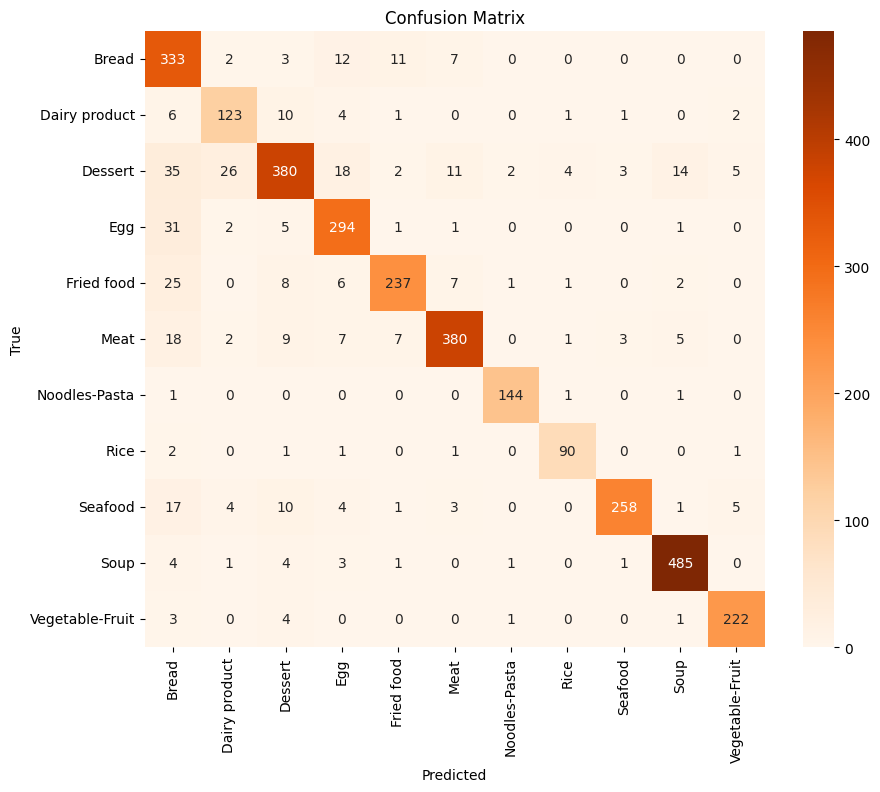

In [ ]:
y_true = []
y_pred = []
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

In [ ]:
metrics(y_true, y_pred)

Precision: 0.89
Recall: 0.88
F1 Score: 0.88


In [ ]:
#VGG

model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 11)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.0MB/s]


Epoch: 1  Train Accuracy: 72.09%  Train Loss: 0.8601095470024158  Validation Accuracy: 82.45%  Validation Loss: 0.525458974750816
Epoch: 2  Train Accuracy: 86.79%  Train Loss: 0.42818561013076684  Validation Accuracy: 84.72%  Validation Loss: 0.4674657541736788
Epoch: 3  Train Accuracy: 92.20%  Train Loss: 0.24781940121529172  Validation Accuracy: 85.92%  Validation Loss: 0.44656887089708847
Epoch: 4  Train Accuracy: 94.61%  Train Loss: 0.16978820727107305  Validation Accuracy: 86.50%  Validation Loss: 0.506942752718546
Epoch: 5  Train Accuracy: 95.72%  Train Loss: 0.134412689964079  Validation Accuracy: 83.59%  Validation Loss: 0.6312777243832964
Test Accuracy: 85 %
Test Loss: 0.5739589842723771


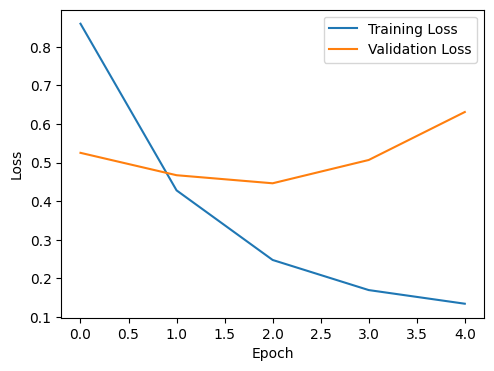

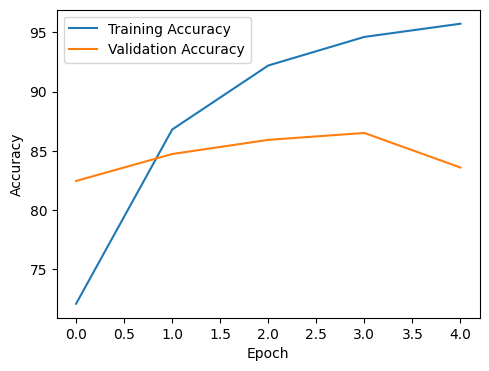

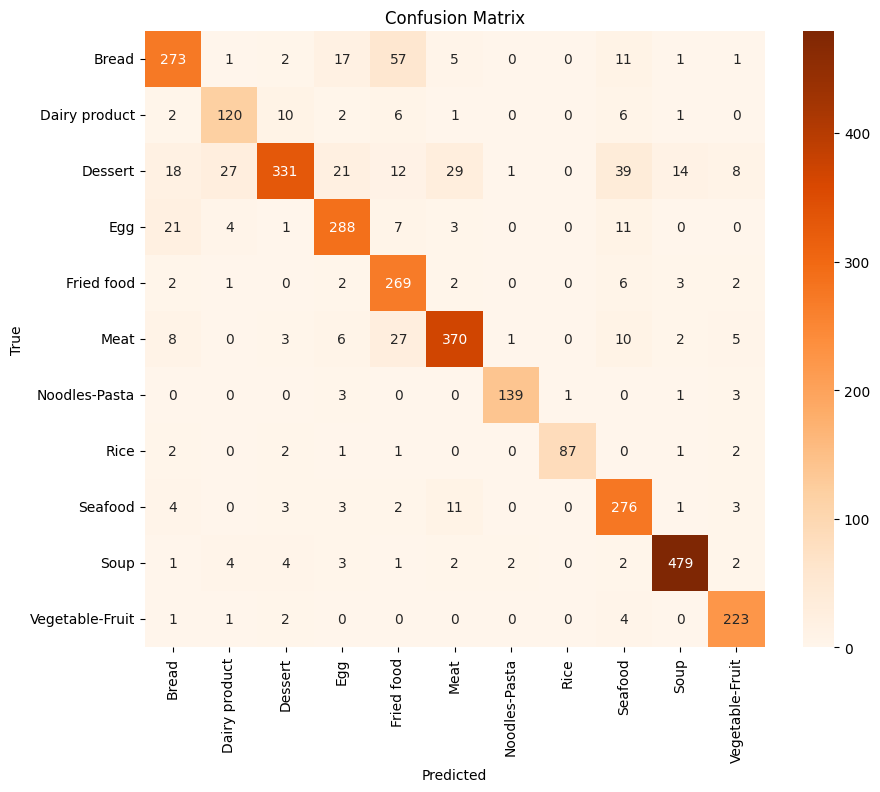

Precision: 0.86
Recall: 0.85
F1 Score: 0.85


In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)
test_accuracy(model, test_loader)

y_true = []
y_pred = []
confusion_plot(model, test_loader)

metrics(y_true, y_pred)

In [ ]:
#densenet
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 11)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 32.9MB/s]


Epoch: 1  Train Accuracy: 78.56%  Train Loss: 0.7106844870114404  Validation Accuracy: 89.01%  Validation Loss: 0.35569305643784227
Epoch: 2  Train Accuracy: 93.32%  Train Loss: 0.22816988511137593  Validation Accuracy: 89.36%  Validation Loss: 0.33337238065346525
Epoch: 3  Train Accuracy: 97.66%  Train Loss: 0.0933021851619374  Validation Accuracy: 90.15%  Validation Loss: 0.31251114593491097
Epoch: 4  Train Accuracy: 98.84%  Train Loss: 0.05126409855909332  Validation Accuracy: 90.76%  Validation Loss: 0.30430243515271554
Epoch: 5  Train Accuracy: 98.39%  Train Loss: 0.05807342142782937  Validation Accuracy: 89.36%  Validation Loss: 0.3136799627962453
Test Accuracy: 91 %
Test Loss: 0.26487421783441234


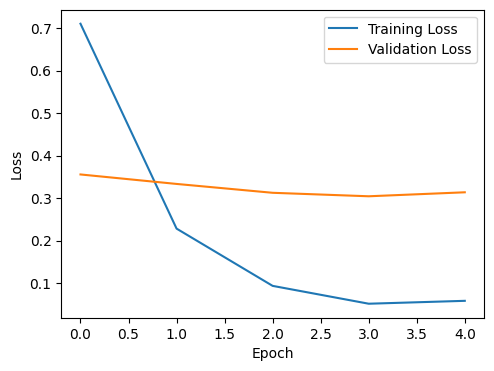

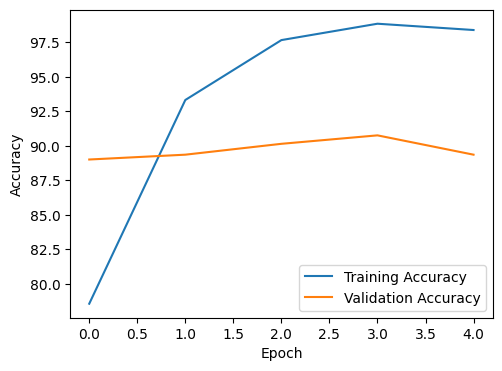

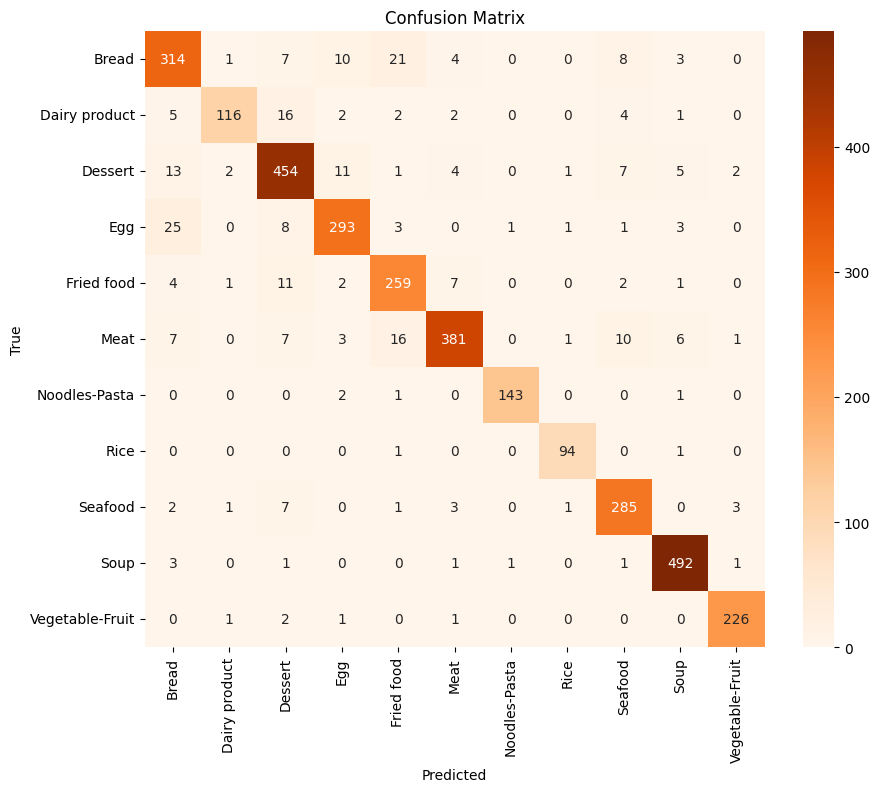

Precision: 0.91
Recall: 0.91
F1 Score: 0.91


In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)
test_accuracy(model, test_loader)

y_true = []
y_pred = []
confusion_plot(model, test_loader)

metrics(y_true, y_pred)